# Pandas Data Pipelines

In this notebook, I will work through the construction of a preprocessing data pipeline in pandas. I will make use of the MovieLens ml-25m dataset. 

The dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 25000095 ratings and 1093360 tag applications across 62423 movies. These data were created by 162541 users between January 09, 1995 and November 21, 2019. This dataset was generated on November 21, 2019.


Reference:

* F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>

In [1]:
## imports ##
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from typing import Dict

## Load in and Explore Data Files

The data are contained in files 'genome-scores.csv', 'genome-tags.csv', 'links.csv', 'movies.csv', 'ratings.csv' and 'tags.csv'. Some descriptive information, provided by the authors of the dataset, is summarised below:

### Identifications 

* User Ids : MovieLens users were selected at random for inclusion. Their ids have been anonymized. User ids are consistent between 'ratings.csv' and 'tags.csv' (i.e., the same id refers to the same user across the two files).
* Movie Ids : Only movies with at least one rating or tag are included in the dataset. Movie ids are consistent between 'ratings.csv', 'tags.csv', 'movies.csv', and 'links.csv' (i.e., the same id refers to the same movie across these four data files).

### Files

* **ratings.csv** : All ratings are contained within this file. Each line of this file represents one rating of one movie by one user, and has the following format: *userId,movieId,rating,timestamp*. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
* **tags.csv** : All tags are contained within this file. Each line of this file represents one tag applied to one movie by one user, and has the following format: *userId,movieId,tag,timestamp*. Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase.
* **movies.csv** : Movie information is contained within this file. Each line of this file represents one movie, and has the following format: *movieId,title,genres*. 
* **links.csv** : Identifiers that can be used to link to other sources of movie data are contained in this file. Each line of this file represents one movie, and has the following format: *movieId,imdbId,tmdbId*. 
* **genome-scores.csv** and **genome-tags.csv** : The tag genome is a data structure that contains tag relevance scores for movies.  The structure is a dense matrix: each movie in the genome has a value for *every* tag in the genome.

In [2]:
# load in data
dfRatings = pd.read_csv('./ml-25m/ratings.csv')
dfTags    = pd.read_csv('./ml-25m/tags.csv')
dfMovies  = pd.read_csv('./ml-25m/movies.csv')
dfGscores = pd.read_csv('./ml-25m/genome-scores.csv')
dfGtags   = pd.read_csv('./ml-25m/genome-tags.csv')

In [3]:
# remove timestamps
dfRatings.drop(['timestamp'],axis=1,inplace=True)
dfTags.drop(['timestamp'],axis=1,inplace=True)

### Check Ratings

In [4]:
# initial view of ratings dataframe
dfRatings.head(5)

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


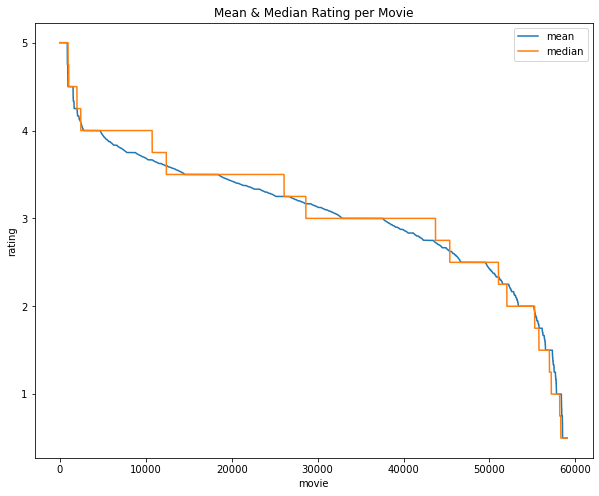

In [5]:
# what is the mean/median distribution of movie ratings?
sMean = dfRatings.groupby(by=['movieId'])['rating'].mean().sort_values(ascending=False)
sMedian = dfRatings.groupby(by=['movieId'])['rating'].median().sort_values(ascending=False)
plt.subplots(figsize=(10, 8))
plt.plot(sMean.values,label='mean')
plt.plot(sMedian.values,label='median')
plt.xlabel('movie')
plt.ylabel('rating')
plt.title('Mean & Median Rating per Movie')
plt.legend()
plt.show()

In [6]:
# compute the number of mean/median ratings >= 4.0
print('Percentage of mean ratings greater than or equal to 4.0: {}'.format(sMean[sMean >= 4.0].shape[0]/sMean.shape[0]))
print('Percentage of median ratings greater than or equal to 4.0: {}'.format(sMedian[sMedian >= 4.0].shape[0]/sMedian.shape[0]))

Percentage of mean ratings greater than or equal to 4.0: 0.07954680170034041
Percentage of median ratings greater than or equal to 4.0: 0.18171964706081595


This plot shows how ratings are distributed over the range of movies we have in the data. Movies are sorted in descending order, as such the labels on the x-axis are a count on the number of movies. The y-axis is the mean/median rating for each movie. It's apparent that only a minority of the movies in our data are typically rated very highly (>= 4.0). The percentage mean rating >= 4.0 is approximately 8%, whereas the median rating >= 4.0 is 18%. 

The only preparation done directly on this dataframe is to remove the timestamp. Let's package this into a single function:

In [7]:
def prepare_ratings(dfRatings: pd.DataFrame) -> pd.DataFrame:
    """
    function to preprocess ratings dataframe
    
    Inputs:
        dfRatings -> dataframe containing ratings information
        
    Outputs:
        ratings dataframe without timestamp column 
    """
    dfRatings.drop(['timestamp'],axis=1,inplace=True)
    return dfRatings

### Process Tags

In [8]:
# initial view of tags dataframe
dfTags.head(5)

,userId,movieId,tag
0,3,260,classic
1,3,260,sci-fi
2,4,1732,dark comedy
3,4,1732,great dialogue
4,4,7569,so bad it's good


In [9]:
# initial view of genome tags dataframe
dfGtags.head(5)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [10]:
# initial view of genome scores dataframe
dfGscores.head(5)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [11]:
## initial preparation ##

# set tags to lower case
dfTags['tag'] = dfTags.tag.str.lower()
dfGtags['tag'] = dfGtags.tag.str.lower()

# join dfTags, dfGtags, & dfGscores
dfTagScores = pd.merge(dfTags,dfGtags,on='tag')
dfTagScores = pd.merge(dfTagScores,dfGscores,on=['movieId','tagId'])

In [12]:
# view the result
dfTagScores.head(5)

,userId,movieId,tag,tagId,relevance
0,3,260,classic,215,0.8865
1,798,260,classic,215,0.8865
2,848,260,classic,215,0.8865
3,3394,260,classic,215,0.8865
4,3448,260,classic,215,0.8865


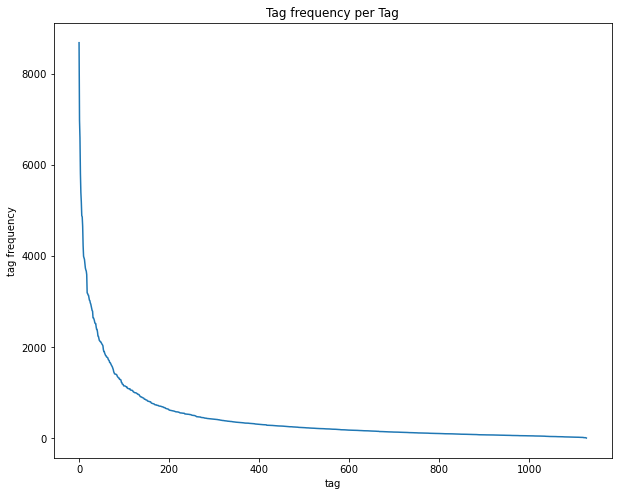

In [13]:
# what is the frequency of tags?
sPlot = dfTagScores.groupby(by=['tagId'])['tag'].count().sort_values(ascending=False)
plt.subplots(figsize=(10, 8))
plt.plot(sPlot.values)
plt.xlabel('tag')
plt.ylabel('tag frequency')
plt.title('Tag frequency per Tag')
plt.show()

We can see there's a large spread in terms of tag frequencies. The most common tags peak over 8000, and then rapidly fall until they level off around 1000.

However, what we really want to know is what are the most common tags used across various userId's? Let's investigate this now:

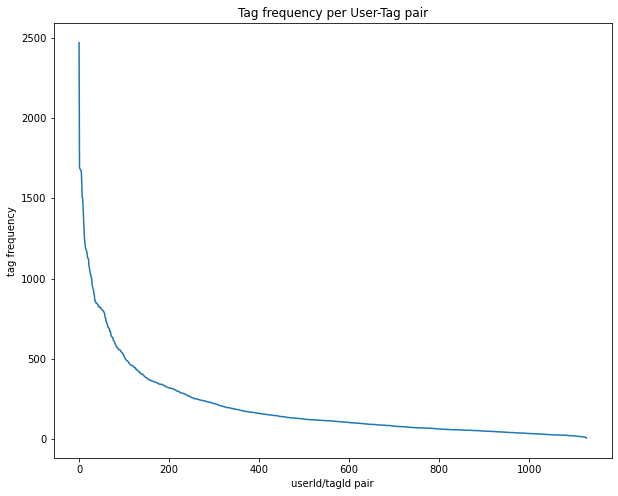

In [14]:
# what is the frequeny of tags being used across different userId's?
dfPlot = dfTagScores[['userId','tagId']].copy()
dfPlot.drop_duplicates(inplace=True)
dfPlot['occurance'] = 1
sPlot = dfPlot.groupby(by=['tagId'])['occurance'].sum().sort_values(ascending=False)
plt.subplots(figsize=(10, 8))
plt.plot(sPlot.values)
plt.xlabel('userId/tagId pair')
plt.ylabel('tag frequency')
plt.title('Tag frequency per User-Tag pair')
plt.show()

This figure follows a similar form to the previous, although the scale of the vertical axis is reduced. We can see only the first 200 tags are popularly used among different users. Hence we'll limit our analysis to only these tags. 

In [15]:
# set cutoff threshold
threshold = 200

# extract usable tagId's
tagIds = sPlot[:threshold].index

In [16]:
# OHE the tags, then multiply in the relevance
sTags = dfTagScores[dfTagScores.tagId.isin(tagIds)].tag
dfOHE = pd.get_dummies(sTags)
dfTagsOHE = dfOHE.mul(dfTagScores.relevance,axis=0)

In [17]:
# do final assembly of tags dataframe
dfTags = pd.concat([dfTagScores[['userId','movieId','tagId']],dfTagsOHE],axis=1)

In [18]:
# view the final result
dfTags.head(5)

,userId,movieId,tagId,absurd,action,adventure,aliens,alternate reality,animation,anime,...,virtual reality,visually appealing,visually stunning,war,weird,western,whimsical,witty,world war ii,zombies
0,3,260,215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,798,260,215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,848,260,215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3394,260,215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3448,260,215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Okay, we've demonstrated the steps we want to take here. Now let's wrap this all up into a function we can call later:

In [19]:
def prepare_tags(dfRatings: pd.DataFrame,
                 dfTags: pd.DataFrame, 
                 dfGtags: pd.DataFrame, 
                 dfGscores: pd.DataFrame, 
                 threshold: float) -> pd.DataFrame:
    """
    function to execute preprocessing on the tags dataframes
    
    Inputs:
        dfRatings -> dataframe containing ratings information
        dfTags    -> dataframe containing tags information
        dfGtags   -> dataframe containing tag genome information
        dfGscores -> dataframe containing tag relevance information
        thresold  -> cutoff threshold based upon tag popularity
        
    Output:
        dataframe containing the prepared tags features merged to dfRatings
    """
    # drop timestamp column
    dfTags.drop(['timestamp'],axis=1,inplace=True)
    
    # set tags to lower case
    dfTags['tag'] = dfTags.tag.str.lower()
    dfGtags['tag'] = dfGtags.tag.str.lower()

    # join dfTags, dfGtags, & dfGscores
    dfTagScores = pd.merge(dfTags,dfGtags,on='tag')
    dfTagScores = pd.merge(dfTagScores,dfGscores,on=['movieId','tagId'])
    
    # extract usable tagId's based on cutoff threshold
    dfTagIds = dfTagScores[['userId','tagId']].copy()
    dfTagIds.drop_duplicates(inplace=True)
    dfTagIds['occurance'] = 1
    sTagIds = dfTagIds.groupby(by=['tagId'])['occurance'].sum().sort_values(ascending=False)
    tagIds = sTagIds[:threshold].index
    
    # OHE the tags, then multiply in the relevance
    sTags = dfTagScores[dfTagScores.tagId.isin(tagIds)].tag
    dfOHE = pd.get_dummies(sTags)
    dfTagsOHE = dfOHE.mul(dfTagScores.relevance,axis=0)
    
    # do final assembly of tags dataframe
    dfTags = pd.concat([dfTagScores[['userId','movieId','tagId']],dfTagsOHE],axis=1)
    
    # return merged results
    return pd.merge(dfRatings,dfTags,on=['userId','movieId'])

### Process Movies

In [20]:
# initial view of movies dataframe
dfMovies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
# obtain the unique set of genres 
raw_genres = dfMovies.genres.unique()
genres     = [g.split('|') for g in raw_genres]
genres     = list(set(chain(*genres)))

In [22]:
# helper function for use when creating genre features
def flag_genre(row):
    applicable_genres = row['genres'].split('|')
    for genre in applicable_genres:
        row[genre] = 1
    return row

In [23]:
# create a set of binary features for each genre
dfGenres = pd.DataFrame(0,columns=genres,index=np.arange(dfMovies.shape[0]))
dfMovies = pd.concat([dfMovies, dfGenres], axis=1, join='inner')
dfMovies = dfMovies.apply(flag_genre, axis=1)

In [24]:
# view the result
dfMovies.head(5)

,movieId,title,genres,Documentary,Mystery,Film-Noir,Romance,Musical,Children,Action,...,War,Horror,Fantasy,Drama,Thriller,Western,Comedy,(no genres listed),Adventure,IMAX
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Ok this all looks good. Our last steps here will be to:
* remove unnecessary columns
* join this result with the other processed dataframes
* multiply the rating, given by a user for a movie, through the genres columns

In [25]:
#drop irrelevant columns
dfMovies.drop(['title','genres'],axis=1,inplace=True)

In [26]:
#final merge
dfPrepared1 = pd.merge(dfRatings,dfTags,on=['userId','movieId'])
dfPrepared1 = pd.merge(dfPrepared1,dfMovies,on='movieId')

In [27]:
# multiply ratings column into movie genres
dfPrepared1.loc[:,genres] = dfPrepared1[genres].mul(dfPrepared1.rating,axis=0)

In [28]:
# view our final product
dfPrepared1.head(5)

,userId,movieId,rating,tagId,absurd,action,adventure,aliens,alternate reality,animation,...,War,Horror,Fantasy,Drama,Thriller,Western,Comedy,(no genres listed),Adventure,IMAX
0,3,260,4.0,215,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
1,3,260,4.0,887,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,264,260,3.0,45,0.0,0.0,0.0,0.85675,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
3,264,260,3.0,942,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
4,264,260,3.0,891,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


Great, we can now build the genre features as we would like. Like before, let's wrap this all up into a function we can call later:

In [29]:
def prepare_movies(dfRatings: pd.DataFrame,
                   dfMovies: pd.DataFrame) -> pd.DataFrame:
    """
    function to execute preprocessing on the movies dataframe
    
    Inputs:
        dfRatings -> dataframe containing ratings information
        dfMovies  -> dataframe containing movies-genre information
        
    Output:
        dataframe containing the prepared movies-genre features merged to dfRatings
    """
    # helper function for use when creating genre features
    def flag_genre(row):
        applicable_genres = row['genres'].split('|')
        for genre in applicable_genres:
            row[genre] = 1
        return row
    
    # obtain the unique set of genres 
    raw_genres = dfMovies.genres.unique()
    genres     = [g.split('|') for g in raw_genres]
    genres     = list(set(chain(*genres)))
    
    # create a set of binary features for each genre
    dfGenres = pd.DataFrame(0,columns=genres,index=np.arange(dfMovies.shape[0]))
    dfMovies = pd.concat([dfMovies, dfGenres], axis=1, join='inner')
    dfMovies = dfMovies.apply(flag_genre, axis=1)
    
    #drop irrelevant columns
    dfMovies.drop(['title','genres'],axis=1,inplace=True)
    
    # merge and multiply through the ratings score
    dfOut               = pd.merge(dfRatings,dfMovies,on='movieId')
    dfOut.loc[:,genres] = dfOut[genres].mul(dfOut.rating,axis=0)
    
    # return
    return dfOut

### Package Everything into a Pipeline

We can now write all our preprocessing steps into a single pipeline. This will make our code much simpler to read, facilitate automation, and facilitate scalability:

In [30]:
# load in data
dfRatings = pd.read_csv('./ml-25m/ratings.csv')
dfTags    = pd.read_csv('./ml-25m/tags.csv')
dfMovies  = pd.read_csv('./ml-25m/movies.csv')
dfGscores = pd.read_csv('./ml-25m/genome-scores.csv')
dfGtags   = pd.read_csv('./ml-25m/genome-tags.csv')

In [31]:
# set cutoff threshold
threshold = 200

In [32]:
# construct a pipeline to carry out the preprocessing work outlined previously
dfPrepared2 = dfRatings.pipe(prepare_ratings) \
                       .pipe(prepare_tags,dfTags=dfTags,dfGtags=dfGtags,dfGscores=dfGscores,threshold=threshold) \
                       .pipe(prepare_movies,dfMovies=dfMovies)

In [33]:
# validate that our output is the same as before
dfPrepared2.equals(dfPrepared1)

True

We can see here that the dataframe produced from the pipeline is the same as the one we generated manually. However, the code used with the pipeline construction is far easier to read holistically. This code is also far more modular, and scalable. Adding more features would equate to adding further stages to the pipeline.